In [1]:
# This notebook is based off of the code at gen.dev
using Gen

In [2]:
import Random

In [ ]:
import Pkg
Pkg.add("Plots")
Pkg.add("StatsBase");

In [20]:
using DelimitedFiles
local_data = readdlm("Desktop/buying-the-news/analysis/dp-ppl-local.csv", ',', Int, '\n');
state_data = readdlm("Desktop/buying-the-news/analysis/dp-ppl-state.csv", ',', Int, '\n');
national_data = readdlm("Desktop/buying-the-news/analysis/dp-ppl-national.csv", ',', Int, '\n');
national_data_no_trump = readdlm("Desktop/buying-the-news/analysis/dp-ppl-national-no-trump.csv", ',', Int, '\n');

In [4]:
using Plots

In [5]:
@gen function regression_with_outliers(xs, μ_m, σ_m, μ_b, σ_b, μ_n, σ_n, α, β)
    """
    xs : observed data
    μ_m, σ_m : gaussian prior hps for slope
    μ_b, σ_b : gaussian prior hps for intercept
    μ_n, σ_n : gaussian hps for outlier data
    α=1, β=1 : gamma hps for ϵ
    """
    slope ~ normal(μ_m, σ_m)
    intercept ~ uniform(μ_b, σ_b)#normal(μ_b, σ_b)
    noise ~ gamma(α, β)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Vector{Float64}(undef, n)
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (μ_n, σ_n)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        ys[i] = ({:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

In [6]:
@gen function line_proposal(current_trace)
    slope ~ normal(current_trace[:slope], 0.5)
    intercept ~ normal(current_trace[:intercept], 0.5)
end; 

function gaussian_drift_update(tr)
    # Gaussian drift on line params
    (tr, _) = mh(tr, line_proposal, ())
    
    # Block resimulation: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block resimulation: Update the prob_outlier parameter
    (tr, w) = mh(tr, select(:prob_outlier))
    (tr, w) = mh(tr, select(:noise))
    tr
end;

import StatsBase

struct RANSACParams
    """the number of random subsets to try"""
    iters::Int

    """the number of points to use to construct a hypothesis"""
    subset_size::Int

    """the error threshold below which a datum is considered an inlier"""
    eps::Float64
    
    function RANSACParams(iters, subset_size, eps)
        if iters < 1
            error("iters < 1")
        end
        new(iters, subset_size, eps)
    end
end


function ransac(xs, ys, params::RANSACParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    for i=1:params.iters
        # select a random subset of points
        rand_ind = StatsBase.sample(1:length(xs), params.subset_size, replace=false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
        A = hcat(subset_xs, ones(length(subset_xs)))
        slope, intercept = A \ subset_ys # use backslash operator for least sq soln
        
        ypred = intercept .+ slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs.(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept)
end;

@gen function ransac_proposal(prev_trace, xs, ys)
    (slope_guess, intercept_guess) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
end;

In [7]:
function make_constraints(ys)
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i] 
    end
    constraints
end;

In [66]:
xs = [state_data[i,1] for i in 1:144]
ys = [state_data[i,2]*50/state_data[i,3] for i in 1:144]
observations = make_constraints(ys);

In [23]:
default(show = true)

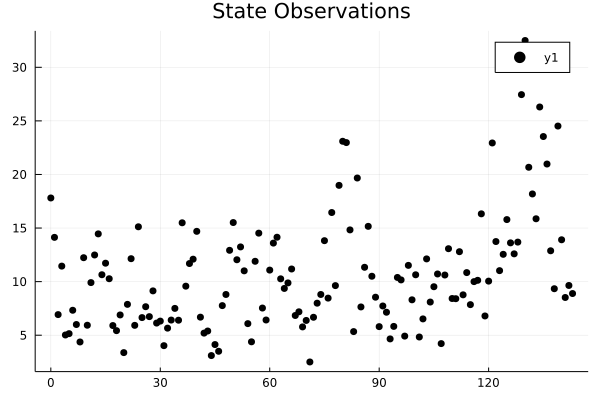

In [67]:
gr()
plt = scatter(xs, ys, color="black", title="State Observations")
display(plt)
#xlabel("X")
#ylabel("Y")
#title("Normalized National Observations");

In [68]:
# note that we linearly rescale the data points so that the data range of the data sets are relatively close
# to one-another. this is useful for the noise hyperparamters. 

hyperparameters_local = (μ_m=0, σ_m=2, μ_b=0, σ_b=20, μ_n=12, σ_n=5, α=1, β=1) # divided by 10
hyperparameters_local_prop = (μ_m=0, σ_m=2, μ_b=0, σ_b=.2, μ_n=.15, σ_n=.5, α=1, β=1) 
hyperparameters_national = (μ_m=0, σ_m=2, μ_b=0, σ_b=20, μ_n=20, σ_n=10, α=1, β=1)  # divided by 50
hyperparameters_national_prop = (μ_m=0, σ_m=2, μ_b=0, σ_b=10, μ_n=15, σ_n=10, α=1, β=1)  # mult by 10
hyperparameters_national_prop_nt = (μ_m=0, σ_m=2, μ_b=0, σ_b=30, μ_n=20, σ_n=10, α=1, β=1)  # mult by 20
hyperparameters_state = (μ_m=0, σ_m=2, μ_b=0, σ_b=20, μ_n=10, σ_n=10, α=1, β=1)  # divided by 15
hyperparameters_state_prop = (μ_m=0, σ_m=2, μ_b=0, σ_b=20, μ_n=15, σ_n=10, α=1, β=1) # mult by 50

(μ_m = 0, σ_m = 2, μ_b = 0, σ_b = 20, μ_n = 15, σ_n = 10, α = 1, β = 1)

In [70]:
trace_sample_state_prop = []
#hyperparameters = (μ_m=0, σ_m=2, μ_b=0.5, σ_b=2, μ_n=1, σ_n=5, α=1, β=1)
# smaller noise variance 
hyperparameters = hyperparameters_state_prop

(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr, _) = generate(regression_with_outliers, 
                      (xs, hyperparameters...), 
                      merge(observations, slope_intercept_init))
for iter = 1:500
    if iter%100 == 0
        print(iter, " ")
    end
    (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
        push!(trace_sample_state_prop, tr)
    end
end


100 200 300 400 500 

In [17]:
function serialize_trace(trace)
    assmt = Gen.get_choices(trace)
    (xs,) = Gen.get_args(trace)
    Dict("slope" => assmt[:slope],
         "intercept" => assmt[:intercept],
         "inlier_std" => assmt[:noise],
         "y-coords" => [assmt[:data => i => :y] for i in 1:length(xs)],
         "outliers" => [assmt[:data => i => :is_outlier] for i in 1:length(xs)])
end;

In [15]:
function save(traces, name, data)
    slopes = [serialize_trace(trace)["slope"] for trace in traces]
    intercepts = [serialize_trace(trace)["intercept"] for trace in traces]
    outliers = [serialize_trace(trace)["outliers"] for trace in traces]
    noise = [serialize_trace(trace)["inlier_std"] for trace in traces]
    writedlm("Desktop/buying-the-news/analysis/dp-ppl-$(name)-posterior.csv",  hcat(slopes, intercepts, noise), ',')
    writedlm("Desktop/buying-the-news/analysis/dp-ppl-$(name)-outliers.csv", 
                                hcat(data, sum(outliers)/length(outliers)), ',')
end;

In [71]:
save(trace_sample_state_prop, "state-prop", state_data)

In [123]:
slopes = [serialize_trace(trace)["slope"] for trace in trace_samples_local_prop]
intercepts = [serialize_trace(trace)["intercept"] for trace in trace_samples_local_prop]
outliers = [serialize_trace(trace)["outliers"] for trace in trace_samples_local_prop];

In [124]:
noise = [serialize_trace(trace)["inlier_std"] for trace in trace_samples_local_prop];

In [125]:
writedlm("Desktop/buying-the-news/analysis/dp-ppl-local-prop-posterior.csv",  hcat(slopes, intercepts, noise), ',')

In [122]:
writedlm("Desktop/buying-the-news/analysis/dp-ppl-national-outliers.csv", 
                                hcat(national_data, sum(outliers)/length(outliers)), ',')

In [80]:
new_xs = [xs[i] for i in 1:length(xs) if local_outliers[i]]
new_ys = [ys[i] for i in 1:length(ys) if local_outliers[i]];

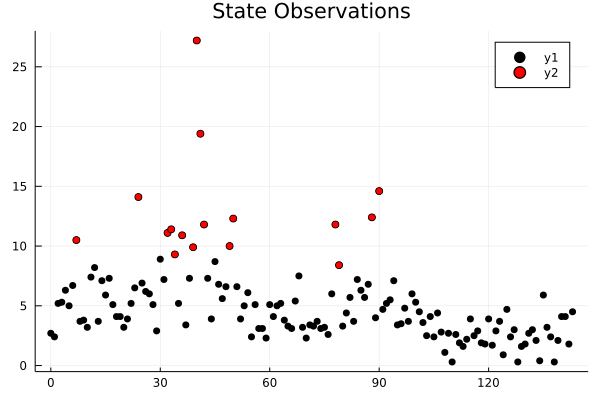

In [81]:
gr()
plt = scatter(xs, ys, color="black", title="State Observations")
scatter!(new_xs, new_ys, color="red")
display(plt)

In [ ]:
new_nat_data = hcat(national_data, national_outliers);

In [104]:
sum(slopes)/length(slopes), sum(intercepts)/length(intercepts), sum(noise)/length(noise)

(0.00021150090556565156, 0.0626867914759614, 1.665666686250702)

In [84]:
sum(slopes)*10/length(slopes), sum(intercepts)/length(intercepts), sum(noise)/length(noise)

(-0.23992610989846763, 5.937733759272802, 1.665666686250702)